## This notebook aim to present the SVD method for recommedation systems 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time 
from numpy.linalg import svd



In [2]:
df_recommendation = pd.read_csv("data/base de donnée_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]


meta_file = "data/meta_Musical_Instruments.jsonl"
with open(meta_file, 'r') as file:
    metadata = [json.loads(line) for line in file]

df_metadata = pd.DataFrame([
    {
        "id": item["parent_asin"],
        "main_category": item["main_category"],
        "title": item["title"],
        "average_rating": item["average_rating"],
        "rating_number": item["rating_number"],
        "features": item["features"],
        "description": item["description"],
        "price": item["price"],
        "images": item["images"],
        "videos": item["videos"],
        "store": item["store"],
        "categories": item["categories"],
        "details": item["details"],
        "bought_together": item["bought_together"],
    }
    for item in metadata
])

In [3]:
ratings.head(3)

,user,id,rating
0,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000EEHKVY,5.0
1,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000TGSM6E,5.0
2,AE23JYHGEN3D35CHE5OQQYJOW5RA,B008FDSWJ0,5.0


In [4]:
ratings_pivot = ratings.pivot(index='user', columns='id', values='rating')

In [5]:
ratings_pivot = ratings_pivot.fillna(0)

### SVD Decomposition Formula

The Singular Value Decomposition of our user-item ranking matrix $ A $ is represented as:
$$
A = U S V^\top
$$

The interaction matrix is decomposed into three matrices:

- **U**: User features matrix.
- **S**: Singular values (a diagonal matrix representing the importance of components).
- **Vᵀ**: Transposed item features matrix.

The decomposition identifies latent features that explain the patterns in user-item interactions.


In [6]:

matrix = ratings_pivot.values
U, S, Vt = svd(matrix, full_matrices=False)


This method gives us the singular value decomposition of our user-item interaction. 

(Note : We use some of Jake Tae git hub work as inspiration for our presentation)

In [7]:
import numpy as np
def cosine_similarity(v,u):
    return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))

col_choice = 0

highest_similarity = -np.inf
highest_sim_col = -1
for col in range(1,Vt.shape[1]):
    similarity = cosine_similarity(Vt[:,col_choice], Vt[:,col])
    if similarity > highest_similarity:
        highest_similarity = similarity
        highest_sim_col = col

In [8]:
print(f"Using Cosine similarity (cf notebook cosine similarity) Product id {ratings_pivot.columns[col]}) is most similar to Product id{ratings_pivot.columns[0]}")

Using Cosine similarity (cf notebook cosine similarity) Product id B0CCK4YYNM) is most similar to Product id1423414357


In [9]:
import matplotlib.pyplot as plt
import random

def plot_data(mat, data_type, camera=None, sample_size=None):
    """
    Plots a 3D scatter plot for the given matrix.
    
    Parameters:
    - mat: DataFrame containing the data to plot. Need to be a DF
    - data_type: Label for the type of data (e.g., 'User', 'Product').
    - camera: Tuple of (elevation, azimuth) for the 3D camera view. Default is None.
    - sample_size: Number of random points to plot. Default is None (plot all).
    """
    # Subsample the data if a sample_size is specified
    if sample_size is not None and sample_size < len(mat):
        mat = mat.sample(n=sample_size, random_state=42)  # Randomly sample rows
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if camera is not None:
        ax.view_init(elev=camera[0], azim=camera[1])
    
    for index, row in mat.iterrows():
        ax.scatter(row[0], row[1], row[2], alpha=0.8)
        ax.text(row[0], row[1], row[2], f'{data_type} {index}', size=5)
    
    plt.title(f"Representation of {data_type} Data ({len(mat)} Points)")
    plt.show()


### **Represenation of items and users on 3D space**

In [10]:
U = pd.DataFrame(U)
print (f"Shape of the matrix U : {U.shape}\n ")

Vt = pd.DataFrame(Vt)
print (f"Shape of the matrix Vt : {Vt.shape}\n ")

S = pd.DataFrame(S)
print (f"Shape of the matrix S: {S.shape}\n ")

Shape of the matrix U : (5107, 1003)
 
Shape of the matrix Vt : (1003, 1003)
 
Shape of the matrix S: (1003, 1)
 


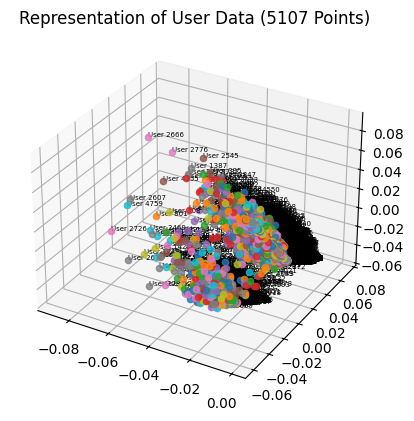

In [11]:
plot_data(U, "User")

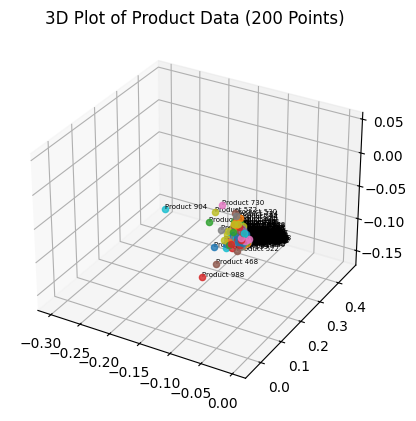

In [12]:
plot_data(Vt.T, "Product", sample_size= 200)

### **Recommendations for each user by reconstructing the ratings matrix.**

In [13]:
U = U.values
Vt = Vt.values
S = S.values.flatten()  # Flatten S to a 1D array for further calculations

print(f"Shape of the matrix U as Array: {U.shape}\n")
print(f"Shape of the matrix Vt as Array: {Vt.shape}\n")
print(f"Shape of the matrix S as Array: {S.shape}\n")

Shape of the matrix U as Array: (5107, 1003)

Shape of the matrix Vt as Array: (1003, 1003)

Shape of the matrix S as Array: (1003,)



In [14]:

reconstructed_matrix = np.dot(np.dot(U, np.diag(S)), Vt)
reconstructed_df = pd.DataFrame(reconstructed_matrix, index=ratings_pivot.index, columns=ratings_pivot.columns)

# Recommend top-N items for a specific user
def get_recommendations(user_id, reconstructed_df, all_items, nb_recommendation=5):
    """
    Generate top-N recommendations for a specific user.
    Return as (item, score) pairs
    """
    user_ratings = reconstructed_df.loc[user_id]
    already_rated = all_items.loc[user_id][all_items.loc[user_id] > 0].index
    recommendations = user_ratings.drop(already_rated).nlargest(nb_recommendation)
    return recommendations.items()

top_n=5
user = "AE23JYHGEN3D35CHE5OQQYJOW5RA"
print(f"Top Recommendations for user {user}")
for k in get_recommendations(user,reconstructed_df, ratings_pivot, top_n) :
    print(k[0])

Top Recommendations for user AE23JYHGEN3D35CHE5OQQYJOW5RA
B0BPJ4Q6FJ
B000J5UEGQ
B08R5GM6YB
B00005ML71
B0002GW3Y8


In [15]:

def get_recommendations(user_id, reconstructed_df, all_items, nb_recommendation=5):
    """
    Generate top-N recommendations for a specific user.
    Return as (item, score) pairs
    """
    user_ratings = reconstructed_df.loc[user_id]
    already_rated = all_items.loc[user_id][all_items.loc[user_id] > 0].index
    recommendations = user_ratings.drop(already_rated).nlargest(nb_recommendation)
    return recommendations.items()


# Function to plot recommendations
def plot_recommendations(user_id, reconstructed_df, df_metadata, all_items, nb_recommendation=5):
    """
    Plot recommended items for a given user with their images and scores.
    #  `reconstructed_df`: DataFrame with predicted ratings
    #  `df_metadata`: DataFrame with item metadata (including 'id' and 'images')
    #  `ratings_pivot`: Pivoted DataFrame with original ratings
    """
    recommendations = get_recommendations(user_id, reconstructed_df, all_items, nb_recommendation)

        
    fig, axs = plt.subplots(1, nb_recommendation, figsize=(20, 8))
    axs = axs.flatten()
    for i, (item, score) in enumerate(recommendations):

        # Retrieve image URL from metadata
        print(item)
        image_url = df_metadata[df_metadata['id'] == item]['images'].iloc[0][0]['large']
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        
        # Display the image and title
        axs[i].imshow(img)
        axs[i].set_title(f"Item {item}\n", fontsize=10)
        axs[i].axis('off')
    plt.title( f"Recommendation for user {user_id} by SVD method",loc = "center", )
    plt.tight_layout()
    plt.show()


B0BPJ4Q6FJ
B000J5UEGQ
B08R5GM6YB
B00005ML71
B0002GW3Y8


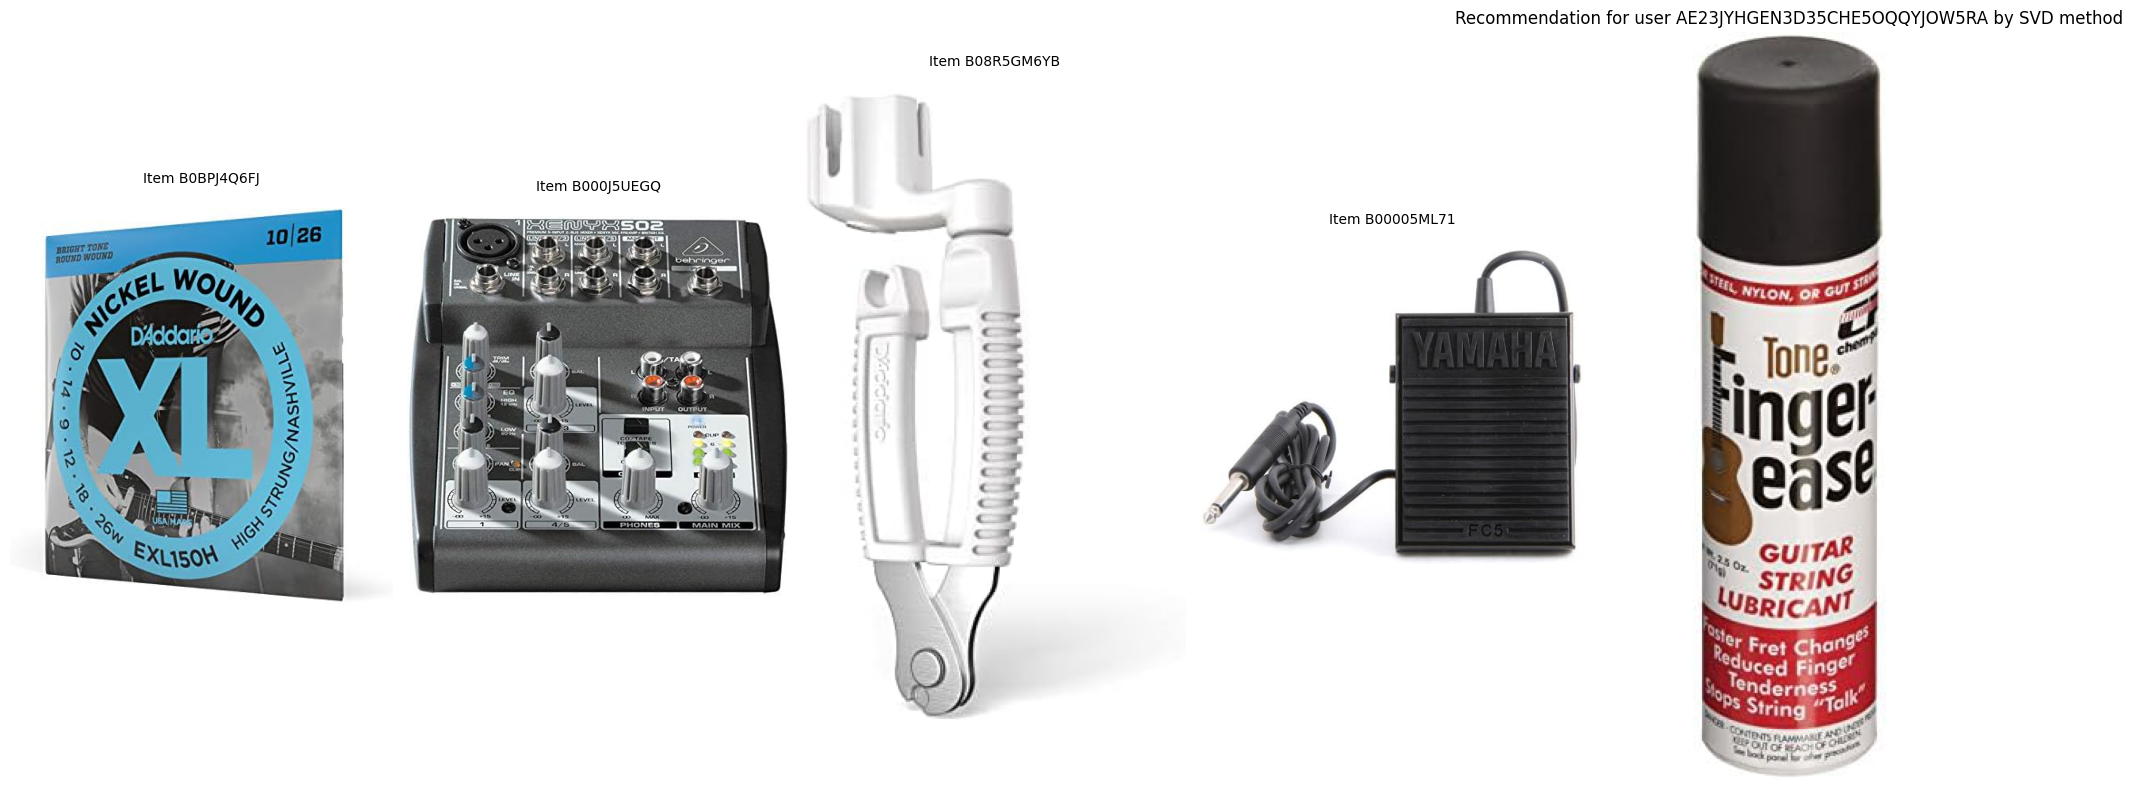

In [16]:
# test user and number of recommendations
test_user_id = "AE23JYHGEN3D35CHE5OQQYJOW5RA"
num_recommendations = 5
plot_recommendations(test_user_id, reconstructed_df, df_metadata, ratings_pivot, num_recommendations)


### **We demonstrate how reducing the number of singular values (truncating S) affects recommendations and computation time.**

In [17]:
reconstructed_matrix = np.dot(np.dot(U, np.diag(S)), Vt)

k = 20  # Choose a reduced number of latent features
U_reduced = U[:, :k]
S_reduced = np.diag(S[:k])
Vt_reduced = Vt[:k, :]
reconstructed_matrix_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)


Full reconstruction time: 0.6538 seconds


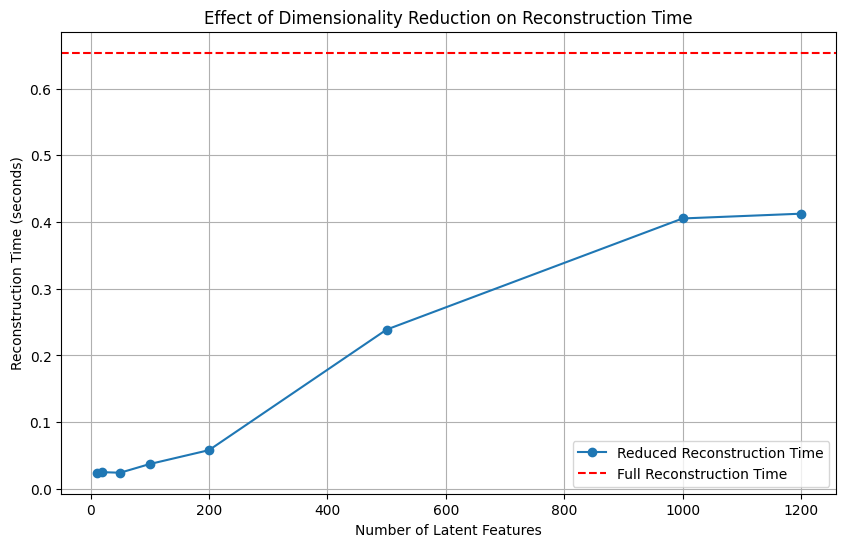

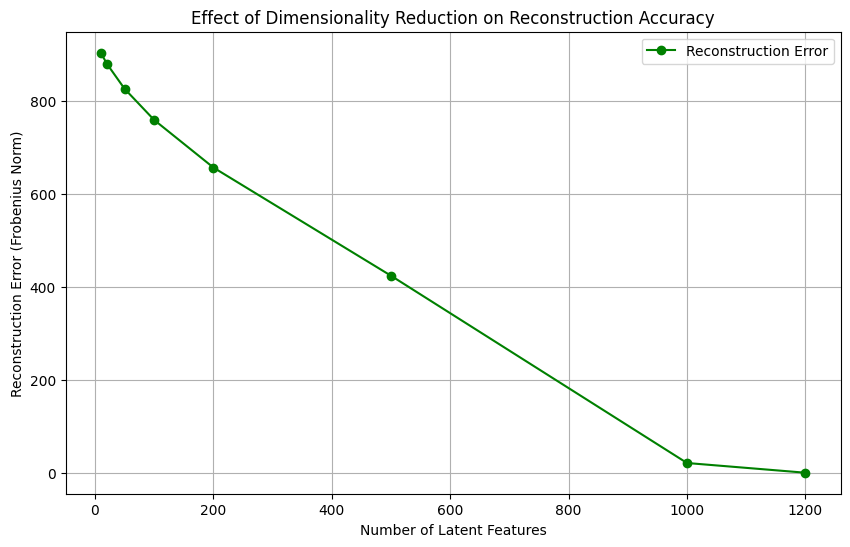

In [26]:
# Different values for k
k_values = [10, 20, 50, 100, 200, 500, 1000, 1200] 
times = []

# Full reconstruction for baseline
start_time = time.time()
S_full = np.diag(S)
reconstructed_full = np.dot(np.dot(U, S_full), Vt)
full_time = time.time() - start_time
print(f"Full reconstruction time: {full_time:.4f} seconds")

# reconstruction time for each k
for k in k_values:
    start_time = time.time()
    U_reduced = U[:, :k]
    S_reduced = np.diag(S[:k])
    Vt_reduced = Vt[:k, :]
    reconstructed_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)
    times.append(time.time() - start_time)


plt.figure(figsize=(10, 6))
plt.plot(k_values, times, marker='o', label="Reduced Reconstruction Time")
plt.axhline(full_time, color='red', linestyle='--', label="Full Reconstruction Time")
plt.title("Effect of Dimensionality Reduction on Reconstruction Time")
plt.xlabel("Number of Latent Features")
plt.ylabel("Reconstruction Time (seconds)")
plt.legend()
plt.grid()
plt.show()

# We Compare accuracy (Reconstruction Error)
errors = []
for k in k_values:
    U_reduced = U[:, :k]
    S_reduced = np.diag(S[:k])
    Vt_reduced = Vt[:k, :]
    reconstructed_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)
    error = np.linalg.norm(ratings_pivot - reconstructed_reduced)  # Frobenius norm
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(k_values, errors, marker='o', color='green', label="Reconstruction Error")
plt.title("Effect of Dimensionality Reduction on Reconstruction Accuracy")
plt.xlabel("Number of Latent Features")
plt.ylabel("Reconstruction Error (Frobenius Norm)")
plt.legend()
plt.grid()
plt.show()

### **Observations:**
For each k, we use the top k singular values and corresponding singular vectors to reconstruct the matrix.


We measure the time taken for reconstruction with reduced dimensions and compare it to the time for full reconstruction. It allows us to shows how computation time decreases as k decreases. It is important because it illustrate too the trade-off between accuracy and efficiency.
